## Standard Split

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix,f1_score,precision_score,recall_score,precision_recall_curve,accuracy_score,classification_report,plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, plot_roc_curve,log_loss
from warnings import filterwarnings
filterwarnings("ignore")

In [5]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier 
from scipy.stats import randint, uniform


In [6]:
data = pd.read_csv('data_v3.csv')

In [7]:
data.head()

,id,current_over,current_ball_of_over,total_extra_runs,current_score,wicket_loss,extras_type,fours_team1,sixes_team1,current_run_rate,balls_left,over_left,projected_score,venue,team1,team2,team2_won_toss,team2_won_match
0,335982,0,1,1,1,0,0,0,0,6.0,119,19,115.0,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0
1,335982,0,2,1,1,0,0,0,0,3.0,118,19,58.0,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0
2,335982,0,2,2,2,0,1,0,0,4.0,118,19,78.0,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0
3,335982,0,3,2,2,0,0,0,0,3.0,117,19,59.0,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0
4,335982,0,4,2,2,0,0,0,0,2.4,116,19,47.6,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0


In [10]:
X = data.drop("team2_won_match",axis =1)
y = data["team2_won_match"]
X = pd.get_dummies(X)
X_train,X_test,y_train,y_test= train_test_split(X,y, stratify=y,test_size=.25)

In [11]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((74884, 74), (24962, 74), (74884,), (24962,))

In [12]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [13]:
X_test_scaled = scaler.transform(X_test)

In [14]:
def accuracy_func(x,y,over,model):
        x_ = x[x["current_over"]>=over]
        y_ = y[x["current_over"]>=over]
        
        x_ = scaler.transform(x_)
        return model.score(x_,y_)
        

In [15]:
def plot_scores(model,name):
    accuracy_list_train = []
    accuracy_list_test = []
    for i in range(20):

        accuracy_list_train.append(accuracy_func(X_train,y_train,i,model))
        accuracy_list_test.append(accuracy_func(X_test,y_test,i,model))

    import matplotlib.pyplot as plt
    plt.plot(range(1,21),accuracy_list_train)
    plt.plot(range(1,21),accuracy_list_test)
    plt.title(name)
    plt.xticks(range(1,21))
    plt.xlabel('Over')
    plt.ylabel('Accuracy_score')
    plt.grid()
    return plt.show()    

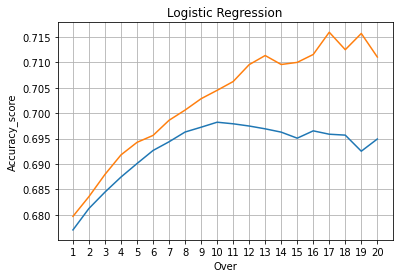

Training Accuracy: 0.6770071043213504
Test Accuracy: 0.6796731031167375
F1Score: 0.6934754274323393


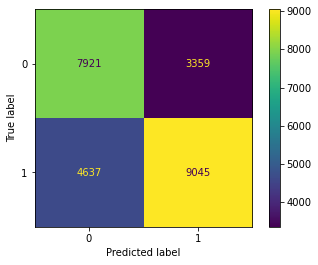

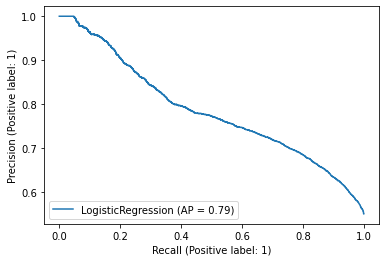

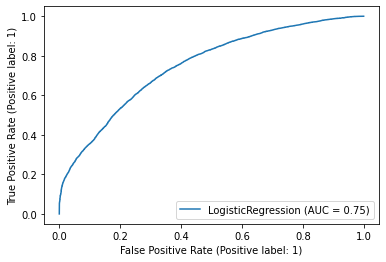

In [17]:
lr = LogisticRegression(penalty='l2', C = 100,solver='lbfgs',class_weight={0:0.1,1:0.08})
lr.fit(X_train_scaled,y_train)
plot_scores(lr,'Logistic Regression')
print('Training Accuracy:',accuracy_score(y_train,lr.predict(X_train_scaled)))
print('Test Accuracy:', accuracy_score(y_test,lr.predict(X_test_scaled)))
plot_confusion_matrix(lr,X_test_scaled,y_test)
plot_precision_recall_curve(lr,X_test_scaled,y_test)
plot_roc_curve(lr, X_test_scaled,y_test)
print('F1Score:', f1_score(y_test,lr.predict(X_test_scaled)))

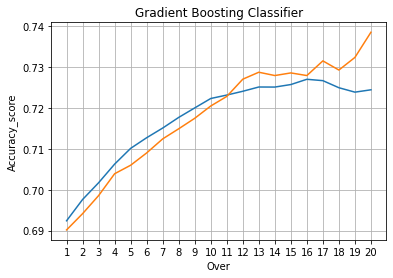

Training Accuracy: 0.6924042519096202
Test Accuracy: 0.6901690569665893
F1Score: 0.7411646586345382


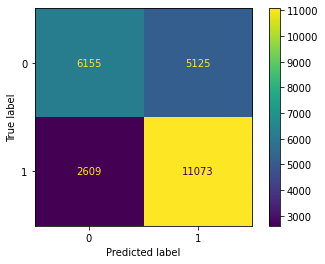

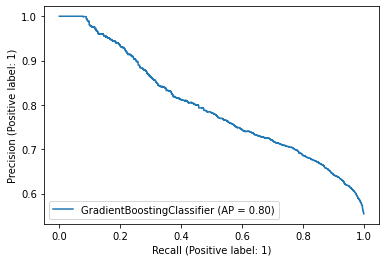

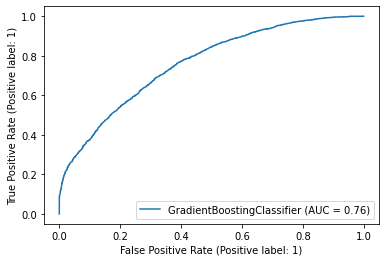

In [25]:
gbdt = GradientBoostingClassifier(
                            max_depth=2,
                            max_features=0.3,
                            min_samples_leaf=3,
                            n_estimators = 100
                            )


gbdt.fit(X_train_scaled,y_train)

plot_scores(gbdt,'Gradient Boosting Classifier')
print('Training Accuracy:',accuracy_score(y_train,gbdt.predict(X_train_scaled)))
print('Test Accuracy:', accuracy_score(y_test,gbdt.predict(X_test_scaled)))
plot_confusion_matrix(gbdt,X_test_scaled,y_test)
plot_precision_recall_curve(gbdt,X_test_scaled,y_test)
plot_roc_curve(gbdt, X_test_scaled,y_test)
print('F1Score:', f1_score(y_test,gbdt.predict(X_test_scaled)))

In [20]:
import pickle

In [102]:
import pickle
with open("saved_pickle/model_gbdt_std_inn1.pkl", 'wb') as f:
    pickle.dump(gbdt,f)

In [23]:
with open("saved_pickle/model_gbdt_std_inn1.pkl", 'rb') as f:
    gbdt = pickle.load(f)

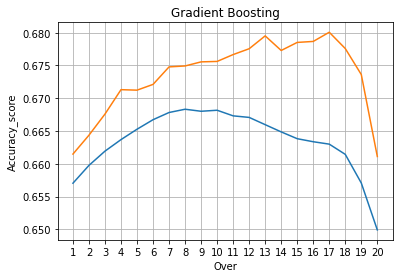

In [24]:
plot_scores(gbdt,'Gradient Boosting')

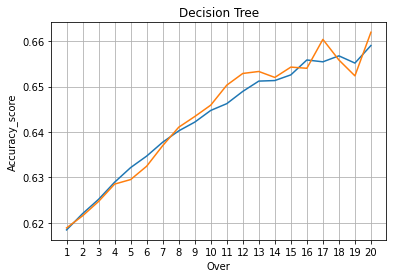

Training Accuracy: 0.6184632231184232
Test Accuracy: 0.6189007291082446
F1Score: 0.6815305815004519


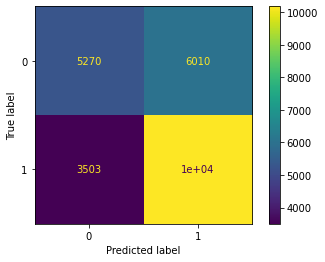

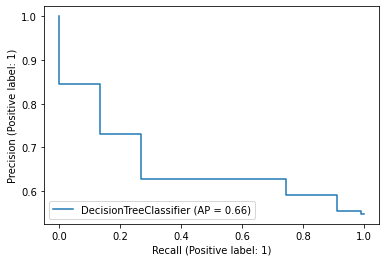

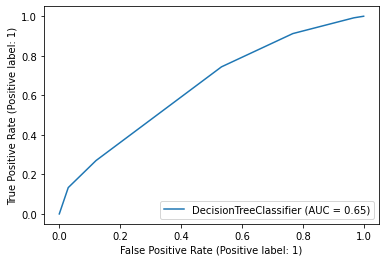

In [26]:
from sklearn.tree import DecisionTreeClassifier

#Hyper Parameter Tuning
param_dist = {  "splitter":['best','random'],
                "criterion":['gini','entropy'],
                "max_features":uniform(0.1,1.0),
                "max_depth":range(1,7),
                "max_leaf_nodes":range(1,7)
            }
clf = RandomizedSearchCV(DecisionTreeClassifier(class_weight={0:0.6,1:0.5}),
                        param_distributions= param_dist,n_iter=50, cv=5)
clf.fit(X_train_scaled,y_train)
dtc = clf.best_estimator_

dtc.fit(X_train_scaled,y_train)
# dtc = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=3, max_features=0.3).fit(X_train_scaled,y_train)
plot_scores(dtc, 'Decision Tree')
print('Training Accuracy:',accuracy_score(y_train,dtc.predict(X_train_scaled)))
print('Test Accuracy:', accuracy_score(y_test,dtc.predict(X_test_scaled)))
plot_confusion_matrix(dtc,X_test_scaled,y_test)
plot_precision_recall_curve(dtc,X_test_scaled,y_test)
plot_roc_curve(dtc, X_test_scaled,y_test)
print('F1Score:', f1_score(y_test,dtc.predict(X_test_scaled)))

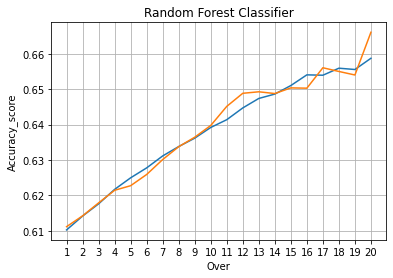

Training Accuracy: 0.6102104588430105
Test Accuracy: 0.6111289159522474
F1Score: 0.680364845730844


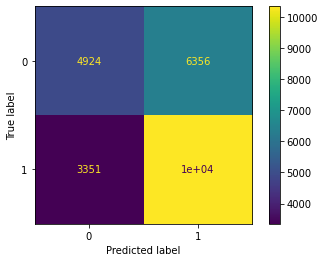

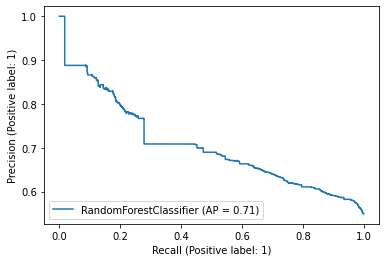

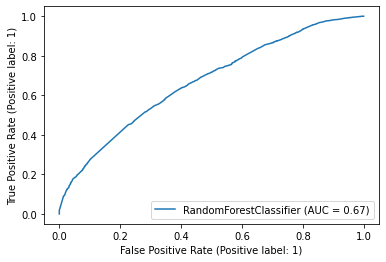

In [27]:
rfc = RandomForestClassifier(n_estimators= 100,
                             max_depth=2, 
                             max_leaf_nodes=3, 
                             max_features=0.3).fit(X_train_scaled,y_train)
plot_scores(rfc,'Random Forest Classifier')
print('Training Accuracy:',accuracy_score(y_train,rfc.predict(X_train_scaled)))
print('Test Accuracy:', accuracy_score(y_test,rfc.predict(X_test_scaled)))
plot_confusion_matrix(rfc,X_test_scaled,y_test)
plot_precision_recall_curve(rfc,X_test_scaled,y_test)
plot_roc_curve(rfc, X_test_scaled,y_test)
print('F1Score:', f1_score(y_test,rfc.predict(X_test_scaled)))

In [28]:
models_data = pd.DataFrame(columns=["Model Name","Train Accuracy","Test Accuracy","Log Loss","Precision","Recall","F1 Score"])
models_data

,Model Name,Train Accuracy,Test Accuracy,Log Loss,Precision,Recall,F1 Score


In [29]:
def update_models_data(model,model_name):
    global models_data
   
    model.fit(X_train_scaled,y_train)
    out = model.predict(X_test_scaled)
    out_proba = model.predict_proba(X_test_scaled)
    trn_acc = accuracy_score(y_train,model.predict(X_train_scaled))
    tst_acc = accuracy_score(y_test,out)
    l_loss = log_loss(y_test,out_proba)
    prec = precision_score(y_test,out)
    rec = recall_score(y_test,out)
    f1 = f1_score(y_test,out)
    
    models_data = models_data.append({"Model Name": model_name,
                        "Train Accuracy":trn_acc,
                        "Test Accuracy":tst_acc,
                        "Log Loss":l_loss,
                        "Precision":prec,
                        "Recall":rec,
                        "F1 Score":f1,
                        },
                       ignore_index = True)

In [30]:
update_models_data(lr,'Logistic Regression')
update_models_data(dtc,'Decision Tree')
update_models_data(rfc,'Random Forest')
update_models_data(gbdt,'Gradient Boosting')

## Performance Chart for Standard Split data

In [31]:
models_data

,Model Name,Train Accuracy,Test Accuracy,Log Loss,Precision,Recall,F1 Score
0,Logistic Regression,0.677007,0.679673,0.587542,0.7292,0.661088,0.693475
1,Decision Tree,0.618463,0.618901,0.651462,0.62876,0.74397,0.681531
2,Random Forest,0.610785,0.611449,0.657755,0.618718,0.758588,0.681551
3,Gradient Boosting,0.690989,0.692212,0.583879,0.683444,0.816767,0.744181


In [44]:
accuracy_score(y_test,lr.predict(X_test)),accuracy_score(y_train,lr.predict(X_train))

(0.6470588235294118, 0.7131147540983607)

In [45]:
print(classification_report(y_test,lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61        92
           1       0.68      0.68      0.68       112

    accuracy                           0.65       204
   macro avg       0.64      0.64      0.64       204
weighted avg       0.65      0.65      0.65       204



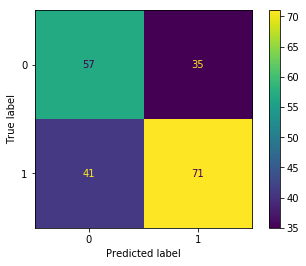

In [33]:
plot_confusion_matrix(lr,X_test,y_test)

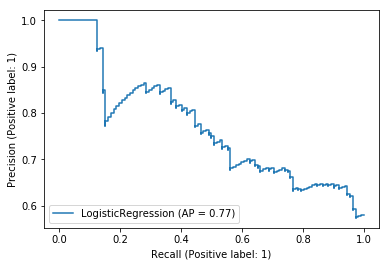

In [47]:
plot_precision_recall_curve(lr,X_test,y_test)

In [51]:
import numpy as np
pred_proba = lr.predict_proba(X_test)
total_true = y_test.sum()
for x in np.arange(.99,0,-.1):
    right = (y_test[pred_proba[:,1]>x] == 1).sum()/(pred_proba[:,1]>x).sum()
    print(f"Threshold {x:.2f} can detect {((y_test[pred_proba[:,1]>x] == 1).sum()/total_true)*100 :.2f}% of team 2 winning with precision of {right:.2f} ")

Threshold 0.99 can detect 0.00% of team 2 winning with precision of nan 
Threshold 0.89 can detect 8.04% of team 2 winning with precision of 1.00 
Threshold 0.79 can detect 23.21% of team 2 winning with precision of 0.84 
Threshold 0.69 can detect 38.39% of team 2 winning with precision of 0.81 
Threshold 0.59 can detect 55.36% of team 2 winning with precision of 0.73 
Threshold 0.49 can detect 70.54% of team 2 winning with precision of 0.67 
Threshold 0.39 can detect 80.36% of team 2 winning with precision of 0.63 
Threshold 0.29 can detect 91.07% of team 2 winning with precision of 0.64 
Threshold 0.19 can detect 97.32% of team 2 winning with precision of 0.59 
Threshold 0.09 can detect 100.00% of team 2 winning with precision of 0.55 


C:\Users\Akash\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
  """
